In [1]:
import pandas as pd

df = pd.read_csv("concatenated_clinical.csv")

print("Önce:", df['treatments.treatment_type'].notna().sum())
df = df[df['cases.submitter_id'].str.startswith("TCGA")]
print("Sonra:", df['treatments.treatment_type'].notna().sum())


# diagnoses.primary_diagnosis'e göre sınıflandır
def classify_diagnosis(value):
    if isinstance(value, str):
        val = value.lower()
        if val.startswith("glio"):
            return "Glioblastoma"
        elif val.startswith("oli"):
            return "Oligodendroglioma"
        elif val.startswith("astro"):
            return "Astrocytoma"
    return "unknown"

for col in df.select_dtypes(include=['float64', 'int64']).columns:
    median_val = df[col].median()
    df[col].fillna(median_val, inplace=True)

for col in df.select_dtypes(include=['object']).columns:
    df[col].fillna("Unknown", inplace=True)


df['diagnoses.primary_diagnosis'] = df['diagnoses.primary_diagnosis'].apply(classify_diagnosis)

# Önce 'Unknown' olanları sona at
df = df.sort_values(by='treatments.treatment_type', key=lambda x: x == "Unknown").drop_duplicates(subset=['cases.submitter_id'], keep='first').reset_index(drop=True)


df.to_csv("processed_clinical_with_diagnosis.csv", index=False)

Önce: 2194
Sonra: 1934


/tmp/ipykernel_185556/687367.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_val, inplace=True)
/tmp/ipykernel_185556/687367.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# CSV dosyasını oku
df = pd.read_csv("processed_clinical_with_diagnosis.csv")

# Sadece TCGA kayıtlarını al
df = df[df['cases.submitter_id'].str.startswith("TCGA")].reset_index(drop=True)

# Sayısal ve kategorik sütunları ayır
numeric_cols = df.select_dtypes(include=["float64", "int64"]).columns.tolist()
categorical_cols = df.select_dtypes(include=["object"]).columns.difference(['cases.submitter_id']).tolist()

# Sayısal verileri doldur (eksik verileri 0 ile)
numerical_filled = df[numeric_cols].fillna(0)

# Kategorik verileri one-hot encode et
categorical_encoded = pd.get_dummies(df[categorical_cols], dummy_na=True)

deneme = np.concatenate([numerical_filled, categorical_encoded.values], axis=1)

deneme_df = pd.DataFrame(deneme)

deneme_df.to_csv("deneme.csv", index=False)

# Sayısal verileri normalize et
scaler = StandardScaler()
numerical_scaled = scaler.fit_transform(numerical_filled)

# Klinik verilerin son hali
processed_clinical_features = np.concatenate([numerical_scaled, categorical_encoded.values], axis=1)

print(f"Klinik veri boyutu: {processed_clinical_features.shape}")


Klinik veri boyutu: (1009, 41)


In [3]:
import numpy as np
import pandas as pd
import os
from tensorflow.keras.models import load_model

vgg16 = load_model('vgg_model.keras')

vgg16.summary()


2025-05-17 12:57:31.190709: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-17 12:57:31.198175: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747475851.206163  185556 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747475851.208571  185556 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747475851.214820  185556 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 19,681,995 (75.08 MB)

 Trainable params: 2,442,371 (9.32 MB)

 Non-trainable params: 12,354,880 (47.13 MB)

 Optimizer params: 4,884,744 (18.63 MB)

In [3]:
import numpy as np
import tensorflow as tf


deneme = np.load("Readformlp/TCGA-TM-A7CF_5b.npy")

print(deneme.shape)

feature_extractor = tf.keras.Model(
    inputs=vgg16.input,
    outputs=vgg16.get_layer("global_average_pooling2d").output
)

(2500, 240, 240)


In [4]:
import tensorflow as tf

print("GPU Available:", tf.config.list_physical_devices('GPU'))


GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder
import cv2
import tensorflow as tf

# Klinik veri
clinical_df = pd.read_csv('processed_clinical_with_diagnosis.csv')

# Klinik verideki tüm ID'ler
clinical_ids = clinical_df['cases.submitter_id'].tolist()


folder_path = 'Readformlp'
clinical_ids = clinical_df['cases.submitter_id'].tolist()

folder_path = 'Readformlp'
clinical_ids = clinical_df['cases.submitter_id'].tolist()

features = []
file_ids = []

for fname in os.listdir(folder_path):
    if fname.endswith('.npy'):
        case_id = fname[:12]
        if case_id in clinical_ids:
            arr = np.load(os.path.join(folder_path, fname))  # (N, 240, 240)
            
            # Eğer slice sayısı 2500'den küçükse geç
            if arr.shape[0] < 2500:
                continue
            # Eğer büyükse ilk 2500'ü al
            elif arr.shape[0] > 2500:
                arr = arr[:2500]

            # 1. Resize ve 3 kanal ekle
            imgs_resized = np.zeros((2500, 224, 224, 3), dtype=np.float32)
            for i in range(2500):
                resized = cv2.resize(arr[i], (224, 224))
                imgs_resized[i] = np.stack([resized]*3, axis=-1)
            
            # 2. Toplu predict
            feature_vectors = feature_extractor.predict(imgs_resized, batch_size=64, verbose=1)  # (2500, 512) (2500,3)
            
            features.append(feature_vectors)
            file_ids.append(case_id)






I0000 00:00:1747432465.640774    5427 service.cc:152] XLA service 0x73772c0024f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747432465.640795    5427 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-05-17 00:54:25.651646: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747432465.692164    5427 cuda_dnn.cc:529] Loaded cuDNN version 90300


 5/40 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step

I0000 00:00:1747432469.653019    5427 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step


In [7]:

features = np.array(features) 

# 2. Klinik veriyi sadece file_ids ile filtrele ve aynı sıraya getir
clinical_filtered = clinical_df[clinical_df['cases.submitter_id'].isin(file_ids)]
clinical_filtered = clinical_filtered.set_index('cases.submitter_id').loc[file_ids].reset_index()

# 3. "unknown" etiketli satırları çıkar
clinical_filtered = clinical_filtered[clinical_filtered['diagnoses.primary_diagnosis'] != 'unknown']

# 4. Features array'i "unknown" etiketlilere göre filtrele
valid_indices = clinical_filtered.index.tolist()
features_filtered = features[valid_indices]

# 5. Etiketleri encode et
labels = clinical_filtered['diagnoses.primary_diagnosis'].values
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)

print("Etiket sınıfları:", le.classes_)

# 6. Klinik veriden gerekli feature sütunlarını al
clinical_features = clinical_filtered.drop(columns=['cases.submitter_id', 'diagnoses.primary_diagnosis']).values


# 4. Feature extraction ve eğitim için hazır

NameError: name 'features' is not defined

In [6]:
from sklearn.preprocessing import StandardScaler

# Klinik özellikleri al (case_id ve label hariç)
clinical_features_df = clinical_filtered.drop(columns=['cases.submitter_id', 'diagnoses.primary_diagnosis'])

# 1. Kategorik verileri one-hot encode et
clinical_features_encoded = pd.get_dummies(clinical_features_df)

# 2. Sayısal verileri normalize et
scaler = StandardScaler()
clinical_features_scaled = scaler.fit_transform(clinical_features_encoded)
# Etiketler zaten hazır (labels_encoded)
y = labels_encoded

NameError: name 'clinical_filtered' is not defined

In [5]:
from sklearn.preprocessing import StandardScaler

# Klinik özellikleri al (case_id ve label hariç)
clinical_features_df = clinical_filtered.drop(columns=['cases.submitter_id', 'diagnoses.primary_diagnosis','diagnoses.tumor_grade','demographic.vital_status' , 'treatments.treatment_type'])

# 1. Kategorik verileri one-hot encode et
clinical_features_encoded = pd.get_dummies(clinical_features_df)

# 2. Sayısal verileri normalize et
scaler = StandardScaler()
clinical_features_scaled = scaler.fit_transform(clinical_features_encoded)
# Etiketler zaten hazır (labels_encoded)
y = labels_encoded

np.save("y_mlp_pred.npy" , y)
np.save("x_mlp_pred.npy", features_filtered)
np.save("clinic.npy", clinical_features_scaled)


NameError: name 'clinical_filtered' is not defined

In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler

X = np.load("x_mlp_pred.npy")
y = np.load("y_mlp_pred.npy")
clinical_data= np.load("clinic.npy")


print(X.shape[0])



data_min = X.min()
data_max = X.max()
X = (X - data_min) / (data_max - data_min)

features_flat = X.reshape(X.shape[0], -1)



# # Şimdi klinik veriyi birleştirebiliriz
# X_combined = np.concatenate([features_flat, clinical_features_scaled], axis=1)

# print(features_flat.shape)

797


In [2]:
import numpy as np
from collections import Counter

# Örnek y dizisi (categorical olmayan hali)
# y = np.array([0, 2, 1, 0, 2, 2, 1, 0]) gibi

# 1. numpy ile sınıf sayıları ve örnek sayısı
unique_classes, counts = np.unique(y, return_counts=True)
print("Sınıflar:", unique_classes)
print("Her sınıftaki örnek sayısı:", counts)

# 2. collections.Counter ile
class_counts = Counter(y)
print(class_counts)

Sınıflar: [0 1 2]
Her sınıftaki örnek sayısı: [185 511 101]
Counter({np.int64(1): 511, np.int64(0): 185, np.int64(2): 101})


In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, TimeDistributed
from tensorflow.keras.optimizers import Adam

model = Sequential([

    Flatten(input_shape=(X.shape[1], X.shape[2])),
    Dense(4096, activation='relu', ),
    Dropout(0.5),
    Dense(4096, activation='relu' , kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dense(3, activation='softmax')  # 3 sınıf: glioblastoma, astrocytoma, oligodendroglioma
])

model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


/home/ai1/miniconda3/envs/thesis-tensorflow/lib/python3.9/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 7500)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4096)           │    30,724,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │        12,291 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,517,699 (181.27 MB)

 Trainable params: 47,517,699 (181.27 MB)

 Non-trainable params: 0 (0.00 B)

In [3]:
print(np.unique(y, return_counts=True))

(array([0, 1, 2]), array([185, 511, 101]))


In [4]:
import numpy as np
from collections import Counter

# Örnek y dizisi (categorical olmayan hali)
# y = np.array([0, 2, 1, 0, 2, 2, 1, 0]) gibi

# 1. numpy ile sınıf sayıları ve örnek sayısı
unique_classes, counts = np.unique(y, return_counts=True)
print("Sınıflar:", unique_classes)
print("Her sınıftaki örnek sayısı:", counts)

# 2. collections.Counter ile
class_counts = Counter(y)
print(class_counts)

Sınıflar: [0 1 2]
Her sınıftaki örnek sayısı: [185 511 101]
Counter({np.int64(1): 511, np.int64(0): 185, np.int64(2): 101})


In [ ]:
import numpy as np

#
#glioblastoma_label = 1

# y_train ve X_train NumPy array ise
#glioblastoma_idx = np.where(y == glioblastoma_label)[0]  # Glioblastoma etiketli index'ler

# İlk 300 tanesini dışarıda bırak
#glioblastoma_idx_to_remove = glioblastoma_idx[:300]

# Geri kalan index'leri al
#keep_indices = np.setdiff1d(np.arange(len(y)), glioblastoma_idx_to_remove)

# Yeni X ve y
#clinical_data = clinical_data[keep_indices]
#X = X[keep_indices]
#y = y[keep_indices]
#print(y.shape)



(286,)


In [3]:
import numpy as np
from collections import Counter

# Örnek y dizisi (categorical olmayan hali)
# y = np.array([0, 2, 1, 0, 2, 2, 1, 0]) gibi

# 1. numpy ile sınıf sayıları ve örnek sayısı
unique_classes, counts = np.unique(y, return_counts=True)
print("Sınıflar:", unique_classes)
print("Her sınıftaki örnek sayısı:", counts)

# 2. collections.Counter ile
class_counts = Counter(y)
print(class_counts)

Sınıflar: [0 1 2]
Her sınıftaki örnek sayısı: [185 511 101]
Counter({np.int64(1): 511, np.int64(0): 185, np.int64(2): 101})


In [4]:
from tensorflow.keras.utils import to_categorical

y_categorical = to_categorical(y, num_classes=3)
print(y_categorical.shape)
print(X.shape) 
print(clinical_data.shape)

class_indices = np.argmax(y_categorical, axis=1)

# Sınıf bazında say
(unique_classes, counts) = np.unique(class_indices, return_counts=True)

for cls, count in zip(unique_classes, counts):
    print(f"Sınıf {cls} ({['Glioblastoma', 'Astrocytoma', 'Oligodendroglioma'][cls]}): {count} örnek")

2025-05-17 13:04:25.002443: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-17 13:04:25.009464: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747476265.017254  186338 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747476265.019721  186338 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747476265.025858  186338 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

(797, 3)
(797, 2500, 512)
(797, 6)
Sınıf 0 (Glioblastoma): 185 örnek
Sınıf 1 (Astrocytoma): 511 örnek
Sınıf 2 (Oligodendroglioma): 101 örnek


In [5]:
from sklearn.model_selection import train_test_split

# X: VGG16 çıktı tensorun (örneğin shape=(N, 2500, 512))
# clinical_data: klinik veriler (örneğin shape=(N, 28))
# y: etiketler (örneğin one-hot veya integer)

X_train, X_test, clinical_train, clinical_test, y_train, y_test = train_test_split(
    X, clinical_data, y_categorical,    # veya y integer label olabilir
    test_size=0.2,
    random_state=42,
    stratify=y  # stratify parametresi etiketlerin dağılımını korur
)

print(X_train.shape, clinical_train.shape, y_train.shape)
print(X_test.shape, clinical_test.shape, y_test.shape)


(637, 2500, 512) (637, 6) (637, 3)
(160, 2500, 512) (160, 6) (160, 3)


In [6]:
import tensorflow as tf
from tensorflow.keras.models import Model

from tensorflow.keras.layers import Input, Conv1D, GlobalAveragePooling1D, Dense, Dropout, Concatenate



image_input = Input(shape=(2500, 512))  
x = Conv1D(128, kernel_size=5, activation='relu', padding='same')(image_input)
x = Dropout(0.3)(x)
x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)
x = GlobalAveragePooling1D()(x)  # -> (batch, 64)

# Klinik veri girişi
clinical_input = Input(shape=(6,))  # Senin klinik verin kaç feature içeriyorsa

# Birleştirme
combined = Concatenate()([x, clinical_input])  # Doğru kullanım

# MLP Katmanı
fc = Dense(128, activation='relu')(combined)
fc = Dropout(0.5)(fc)
output = Dense(3, activation='softmax')(fc)

# Model tanımı
model = Model(inputs=[image_input, clinical_input], outputs=output)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

I0000 00:00:1747476271.298244  186338 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 697 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 2500, 512) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 2500, 128) │    327,808 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2500, 128) │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 2500, 64)  │     24,640 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ conv1d_1[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 70)        │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │      9,088 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 3)         │        387 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 361,923 (1.38 MB)

 Trainable params: 361,923 (1.38 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping



lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [8]:
class_indices = np.argmax(y_categorical, axis=1)

# Sınıf bazında say
(unique_classes, counts) = np.unique(class_indices, return_counts=True)

for cls, count in zip(unique_classes, counts):
    print(f"Sınıf {cls} ({['Glioblastoma', 'Astrocytoma', 'Oligodendroglioma'][cls]}): {count} örnek")

Sınıf 0 (Glioblastoma): 185 örnek
Sınıf 1 (Astrocytoma): 511 örnek
Sınıf 2 (Oligodendroglioma): 101 örnek


In [10]:
history = model.fit(
    [X_train,clinical_train],
    y_train,
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    callbacks=[lr, es]
)


2025-05-17 13:05:32.328552: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.43GiB (rounded to 2606080000)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2025-05-17 13:05:32.328566: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1058] BFCAllocator dump for GPU_0_bfc
2025-05-17 13:05:32.328570: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1065] Bin (256): 	Total Chunks: 21, Chunks in use: 21. 5.2KiB allocated for chunks. 5.2KiB in use in bin. 384B client-requested in use in bin.
2025-05-17 13:05:32.328572: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1065] Bin (512): 	Total Chunks: 2, Chunks in use: 2. 1.0KiB allocated for chunks. 1.0KiB in use in bin. 1.0KiB client-requested in use in bin.
2025-05-17 

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

17 13:05:32.328652: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1122] 1 Chunks of size 1310720 totalling 1.25MiB
2025-05-17 13:05:32.328653: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1126] Sum Total of in-use chunks: 1.39MiB
2025-05-17 13:05:32.328655: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1128] Total bytes in pool: 730988544 memory_limit_: 730988544 available bytes: 0 curr_region_allocation_bytes_: 1461977088
2025-05-17 13:05:32.328657: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1133] Stats: 
Limit:                       730988544
InUse:                         1454080
MaxInUse:                      3934976
NumAllocs:                          66
MaxAllocSize:                  1310720
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2025-05-17 13:05:32.328659: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:512] *_________________________________________

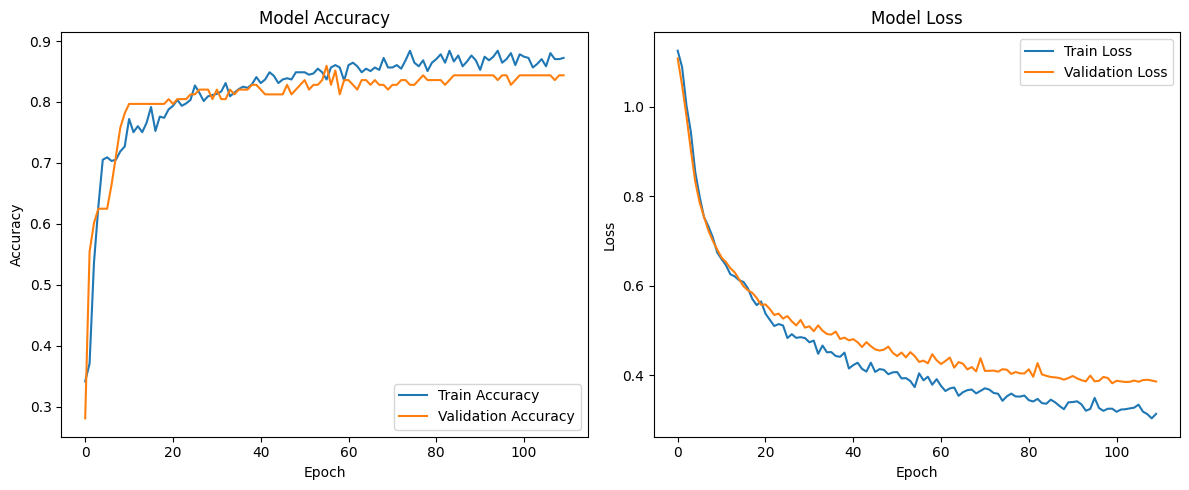

In [134]:
import matplotlib.pyplot as plt

# Eğitim ve doğrulama doğrulukları
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Eğitim ve doğrulama kayıpları
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [68]:
print(y_categorical.shape)

y_true = np.argmax(y_categorical, axis=1)
y_pred = np.argmax(model.predict([X, clinical_data]), axis=1)
print(np.unique(y_true, return_counts=True))
print(np.unique(y_pred, return_counts=True))

print(y_pred)
print(y_true.shape)


(286, 3)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
(array([0, 2]), array([185, 101]))
(array([0, 2]), array([216,  70]))
[2 0 0 2 0 0 0 2 0 0 0 0 2 0 0 0 0 2 0 0 2 2 2 0 0 0 0 2 0 0 0 0 2 0 0 0 0
 0 0 2 0 0 2 0 0 2 0 0 2 0 0 0 2 2 2 0 0 0 2 2 0 0 0 0 0 2 0 0 0 0 2 0 0 0
 0 0 0 0 0 0 0 2 2 2 0 2 0 0 0 0 0 2 0 0 0 0 2 0 0 0 0 0 2 2 2 2 0 0 0 0 0
 0 0 0 0 0 0 2 0 0 0 2 0 2 0 2 0 0 0 0 0 0 0 2 0 0 0 0 0 2 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 2 2 2 0 2 2 0 0 0 0 2 2 0 0 2 0 2 0 0 0 0 0 0 0 2 2 0 0 0 0 2
 2 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 0 0 0 2 0 2 0 0 0
 0 2 0 0 0 0 0 0 2 2 2 0 2 2 0 0 0 2 2 0 0 0 2 0 0 0 2 0 2 0 0 0 0 0 0 0 2
 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 0]
(286,)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
Gerçek sınıflar: (array([0, 1, 2]), array([148, 408,  81]))
Tahmin edilen sınıflar: (array([0, 1, 2]), array([150, 434,  53]))


<Figure size 600x600 with 0 Axes>

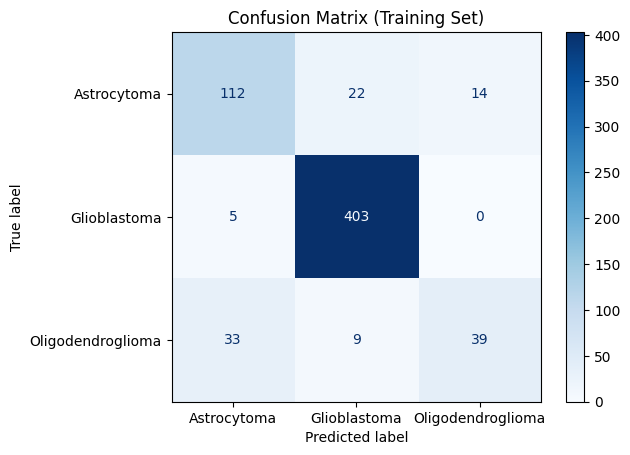

In [135]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Tahminler
y_pred_proba = model.predict([X_train, clinical_train])
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_train, axis=1)

print("Gerçek sınıflar:", np.unique(y_true, return_counts=True))
print("Tahmin edilen sınıflar:", np.unique(y_pred, return_counts=True))

# Sadece mevcut sınıfları kullan
classes_present = np.unique(np.concatenate([y_true, y_pred]))

# Sınıf isimleri
label_names = ['Astrocytoma', 'Glioblastoma', 'Oligodendroglioma']
labels_to_use = [label_names[i] for i in classes_present]

# Confusion matrix hesapla ve çiz
cm = confusion_matrix(y_true, y_pred, labels=classes_present)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_to_use)

plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix (Training Set)")
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Gerçek sınıflar: (array([0, 1, 2]), array([ 37, 103,  20]))
Tahmin edilen sınıflar: (array([0, 1, 2]), array([ 38, 110,  12]))


<Figure size 600x600 with 0 Axes>

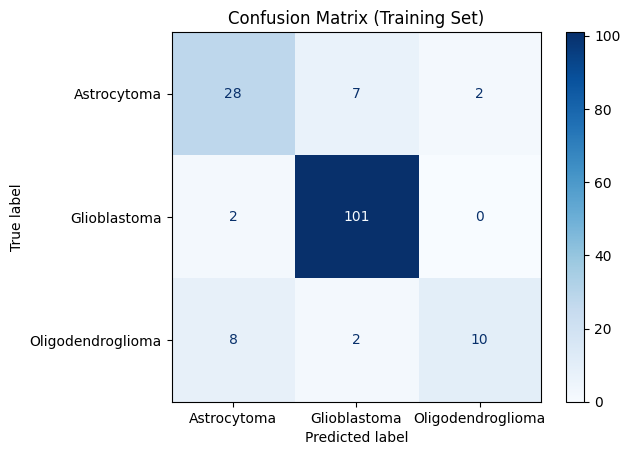

In [136]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Tahminler
y_pred_proba = model.predict([X_test, clinical_test])
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test, axis=1)

print("Gerçek sınıflar:", np.unique(y_true, return_counts=True))
print("Tahmin edilen sınıflar:", np.unique(y_pred, return_counts=True))

# Sadece mevcut sınıfları kullan
classes_present = np.unique(np.concatenate([y_true, y_pred]))

# Sınıf isimleri
label_names = [ 'Astrocytoma','Glioblastoma', 'Oligodendroglioma']
labels_to_use = [label_names[i] for i in classes_present]

# Confusion matrix hesapla ve çiz
cm = confusion_matrix(y_true, y_pred, labels=classes_present)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_to_use)

plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix (Training Set)")
plt.show()


In [ ]:
history = model.fit(
    [X,clinical_data],
    y_categorical,
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    callbacks=[lr, es]
)


Epoch 1/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.2590 - loss: 1.3705

2025-05-17 02:20:11.621503: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_101', 4 bytes spill stores, 4 bytes spill loads



8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 362ms/step - accuracy: 0.2609 - loss: 1.3660 - val_accuracy: 0.1207 - val_loss: 1.2242 - learning_rate: 1.0000e-04
Epoch 2/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2766 - loss: 1.3376 - val_accuracy: 0.1552 - val_loss: 1.1945 - learning_rate: 1.0000e-04
Epoch 3/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3103 - loss: 1.2400 - val_accuracy: 0.2586 - val_loss: 1.1646 - learning_rate: 1.0000e-04
Epoch 4/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3237 - loss: 1.2482 - val_accuracy: 0.4138 - val_loss: 1.1331 - learning_rate: 1.0000e-04
Epoch 5/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3562 - loss: 1.2079 - val_accuracy: 0.5000 - val_loss: 1.0991 - learning_rate: 1.0000e-04
Epoch 6/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3815 - loss: 1.2198 - val_accuracy: 0.5690 - val_loss: 1.0632 - learning_rate: 1.0000e-04
Epoch 7/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3882 - loss: 1.1799 - v

In [ ]:
import matplotlib.pyplot as plt

plt.hist(y, bins=np.arange(len(np.unique(y)) + 1) - 0.5, rwidth=0.8)
plt.xticks(np.unique(y))
plt.xlabel("Sınıf")
plt.ylabel("Adet")
plt.title("Eğitim Verisindeki Sınıf Dağılımı")
plt.show()